In [ ]:
# matthew.lewis@utsouthwestern.edu
# 972-467-0725

In [49]:
# setup env dependencies - only needs to be run once
!conda install --yes scipy
!conda install --yes matplotlib
!conda install --yes scikit-image
!conda install --yes scikit-learn

Channels:
 - defaults
Platform: osx-64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
Platform: osx-64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
Platform: osx-64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-1.7.1         |  py311h20cdf89_0        10.1 MB
    threadpoolctl-3.5.0        |  py311h85bffb1_0          50 KB
    ------------------------------------------------------------
                                           Total:        10.2 MB

The following packages will be UPDATED:

  scikit-learn                        1.2.2-py311

In [2]:
# load dependencies
import numpy as np
from scipy.stats import rice
from skimage.draw import disk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


In [39]:
# configuration

# image matrix size
matrix = np.array( [216,216] )

# b-values to simulate data
bvals = np.array( [0,100,500,500,1000,1600] )    # s/mm^2

# virtual phantom
center = np.array( [106,103] )
r_phantom = 95
S0_background = 10.0
# NEED NOMINAL VALUE
ADC_background = 2000.  # 10^-6 mm^2/s
# uncomment next line if lowest b-value images should be constant SNR  
# S0_background = S0_background * np.exp( ADC_background*(1e-6) * bvals[bvals > 0].min() )   

# virtual inclusions - these arrays must all the same length
r_inclusions = 13   # radius of inclusions
centers_x = np.array( [ 103,49,85,121,155,49,85,122,157,64,98,133 ] )
centers_y = np.array( [ 41,74,71,71,75,108,108,110,113,148,145,142 ] )
S0_inclusions = 10.0 * np.ones( centers_x.size )   # could potentially also have different proton densities
# NEED NOMINAL VALUES
ADC_inclusions = np.array ( [ 832,541,512,778,762,560,618,665,717,1266,1000,874  ] )  # 10^-6 mm^2/s
# uncomment next line if lowest b-value images should be constant SNR 
# S0_inclusions = S0_inclusions * np.exp( ADC_inclusions*(1e-6) * bvals[bvals > 0].min() )

# noise
# THIS AMP GOES TO 11
# This is the parameter to experiment with....
# set it to a very small number to eliminate noise ex. 0.0001
sigma = 1.0
# if need be, different bvals can have different noise floors
noises = sigma * np.ones( bvals.size )

In [40]:
# construct virtual phantom (one slice)
S0 = np.zeros(matrix)
ADC = np.zeros(matrix)
rr, cc = disk((center[0],center[1]), r_phantom, shape=matrix)
S0[rr,cc] = S0_background
ADC[rr,cc] = ADC_background

for i in range( ADC_inclusions.size):
    rr, cc = disk( (centers_x[i] , centers_y[i]), r_inclusions, shape=matrix)
    S0[rr,cc] = S0_inclusions[i]
    ADC[rr,cc] = ADC_inclusions[i]
    
bval_images = np.zeros( np.insert(matrix,0,bvals.size) )
for i in range( bvals.size ):
    temp = S0 * np.exp( -bvals[i]*(1e-6)*ADC )
    if noises[i] > 0:
        temp = rice.rvs( (1/noises[i])*temp, noises[i] )
    bval_images[i,:,:] = temp
        


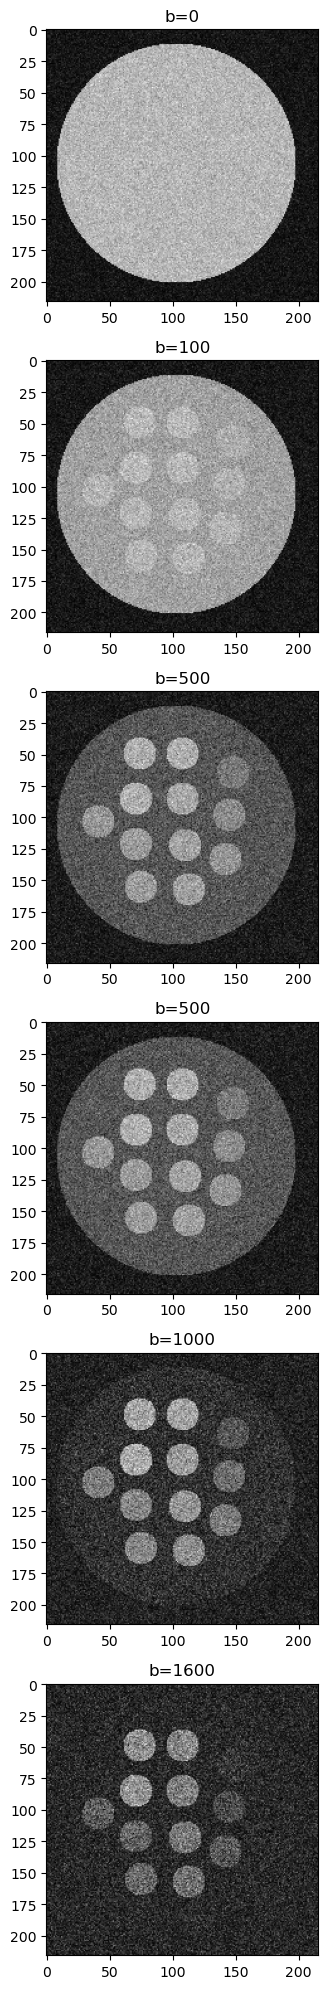

In [41]:
# make a montage
fig, axes = plt.subplots(bval_images.shape[0],figsize=(20,20))

for i, img in enumerate(bval_images):
    #axes[i].imshow(img,cmap='gray',vmin=0.0 ,vmax=S0_background)
    axes[i].imshow(img,cmap='gray')
    axes[i].set_title(f'b={bvals[i]}')
    #axes.axis('off') # Hide axis ticks and labels

plt.tight_layout()
plt.show()

In [42]:
# log-linear regression - there should be a more elegant way to do this
data = -np.log(bval_images)
ADC_map = np.zeros(matrix)
for i in range(matrix[0]):
    for j in range(matrix[1]):
        pts = data[1:bvals.size,i,j]
        m, b = np.polyfit(bvals[1:], pts, 1)
        ADC_map[i,j] = m*(1e6)

        

Text(0.5, 1.0, 'inverse crime... guilty as charged')

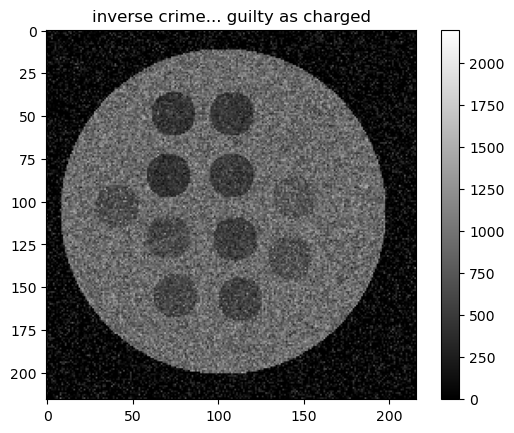

In [43]:
plt.imshow(ADC_map,vmin=ADC.min(),vmax=1.1*ADC.max(),cmap='gray')
plt.colorbar()
plt.title('inverse crime... guilty as charged')

/var/folders/8w/trbksr292db5bgdrllj9ph4m0000gn/T/ipykernel_82137/1763235054.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow( 100.0*(ADC_map-ADC)/ADC)


Text(0.5, 1.0, 'percent error')

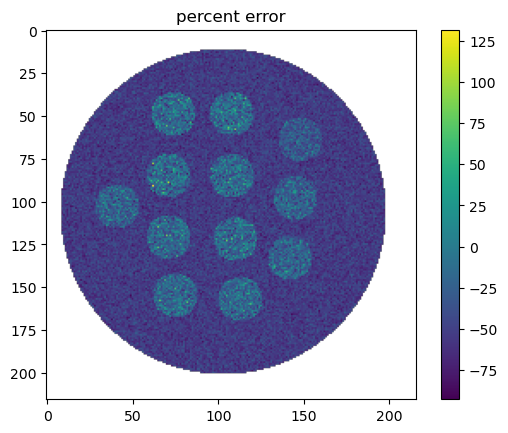

In [8]:
plt.imshow( 100.0*(ADC_map-ADC)/ADC)
plt.colorbar()
plt.title('percent error')

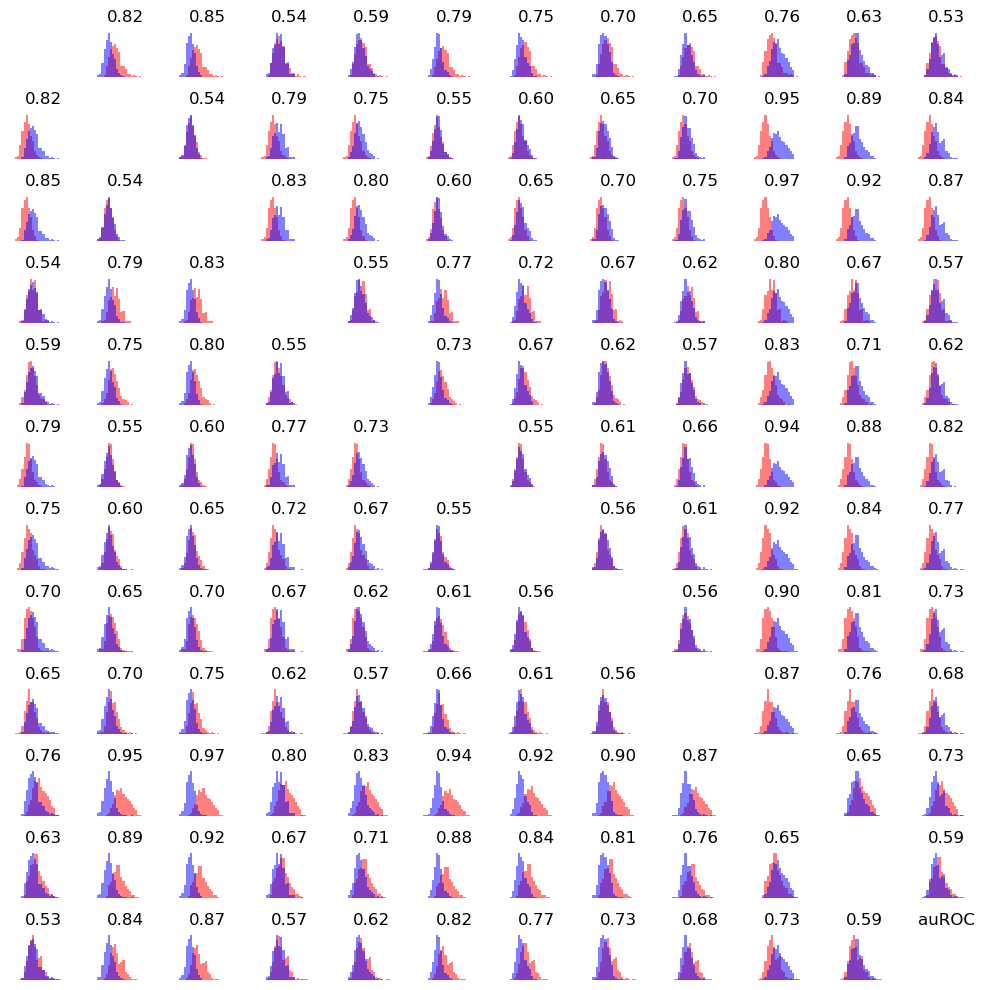

In [50]:
fig, axs = plt.subplots(ADC_inclusions.size, ADC_inclusions.size,figsize=(10,10))
bins = np.linspace(0,2000,30)
for i in range( ADC_inclusions.size):
    for j in range ( ADC_inclusions.size):
        if i != j:
            mask_i = np.zeros(matrix)
            rr, cc = disk( (centers_x[i] , centers_y[i]), r_inclusions, shape=matrix)
            mask_i[rr,cc] = 1
            mask_j = np.zeros(matrix)
            rr, cc = disk( (centers_x[j] , centers_y[j]), r_inclusions, shape=matrix)
            mask_j[rr,cc] = 1

            vector_i = ADC_map[ mask_i > 0 ]
            vector_j = ADC_map[ mask_j > 0 ]

        
            axs[i,j].hist(vector_i, bins, alpha=0.5,color='red')
            axs[i,j].hist(vector_j, bins, alpha=0.5,color='blue')

            all_scores = np.concatenate([vector_i,vector_j])
            true_labels = np.concatenate([np.zeros(len(vector_i)),np.ones(len(vector_j))])
            auroc_score = roc_auc_score(true_labels, all_scores)
            if auroc_score < 0.5:
                auroc_score = 1 - auroc_score
            axs[i,j].set_title(f"{auroc_score:.2f}")
            
        axs[i,j].set_axis_off()

plt.tight_layout()
plt.title('auROC')
plt.show()
        

In [47]:
all_scores = np.concatenate([vector_i,vector_j])
true_labels = np.concatenate([np.zeros(len(vector_i)),np.ones(len(vector_j))])
auroc_score = roc_auc_score(true_labels, all_scores)
print(f"auROC = {auroc_score:.2f}")

auROC = 0.59


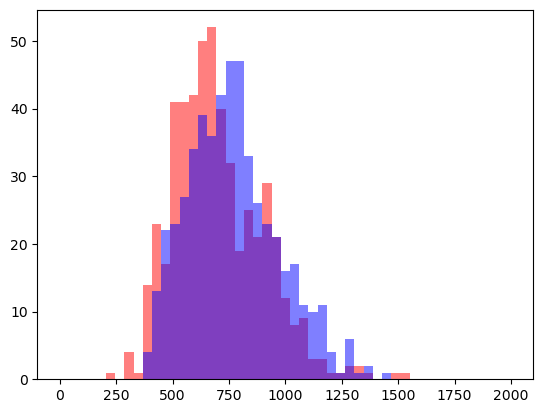

In [48]:
bins = np.linspace(0,2000,50)
plt.hist(vector_i, bins, alpha=0.5,color='red')
plt.hist(vector_j, bins, alpha=0.5,color='blue')
plt.show()